In [1]:
import pandas as pd
from helpers import get_ddsm_table, get_INBreast_table, get_VinDR_table, mask_image, run_intensity_functions, run_glcm_features, get_master_df
import pydicom
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
ddsm_df = get_ddsm_table()
INbreast_df = get_INBreast_table()
vindr_df = get_VinDR_table()

In [3]:
master_df = get_master_df(vindr_df, ddsm_df, INbreast_df)

In [6]:
df_data = []
for i in tqdm(range(len(master_df))):
    row = master_df.iloc[i]
    image_stats = {
        "file_name": row['full_path'],
        "vendor": row['Manufacturer'],
        "laterality": row['laterality'], 
        "view_position": row['view_position'],
        "breast_density": row['breast_density']    
    }
    pixel_array = pydicom.dcmread(row['full_path']).pixel_array
    breast_tissue_image = mask_image(pixel_array)
    intensity_stats, hist_features = run_intensity_functions(breast_tissue_image)
    image_stats.update(intensity_stats)
    image_stats.update(hist_features)
    glcm_stats = run_glcm_features(breast_tissue_image)
    image_stats.update(glcm_stats)
    df_data.append(image_stats)

image_stats_df = pd.DataFrame(df_data)

100%|██████████| 2885/2885 [45:35<00:00,  1.05it/s]


In [7]:
features = np.array(image_stats_df.iloc[:,5:])
labels = image_stats_df['vendor'].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

In [8]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(features_scaled)

c:\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


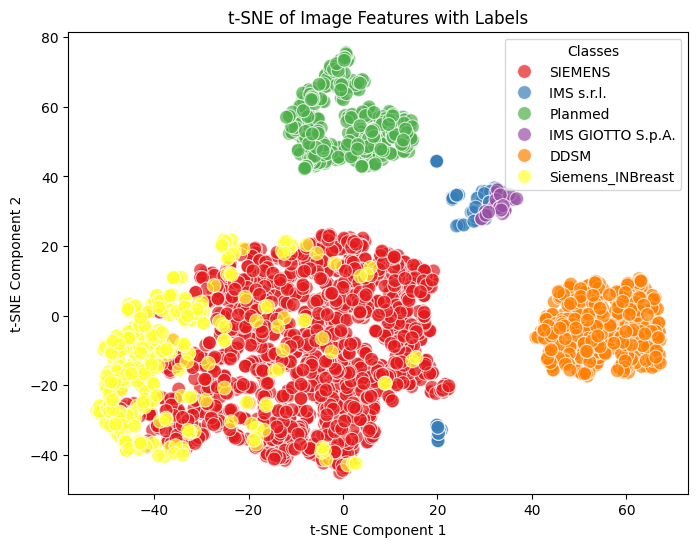

In [9]:
tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
tsne_df['Label'] = label_encoder.inverse_transform(numeric_labels)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Label", palette='Set1', s=100, alpha=0.7)

plt.title("t-SNE of Image Features with Labels")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Classes")

plt.show()

In [10]:
image_stats_df.to_csv('complete_stats.csv', index=False)

In [20]:
image_stats_df.iloc[:,5:].head()

,mean,max,min,std,median,skew,kurtosis,area_under_histogram,hist_1,bin_1,hist_2,bin_2,hist_3,bin_3,hist_4,bin_4,hist_5,bin_5,hist_6,bin_6,hist_7,bin_7,hist_8,bin_8,hist_9,bin_9,hist_10,bin_10,hist_11,bin_11,hist_12,bin_12,hist_13,bin_13,hist_14,bin_14,hist_15,bin_15,hist_16,bin_16,homogeneity_1,correlation_1,contrast_1,dissimilarity_1,ASM_1,energy_1,homogeneity_2,correlation_2,contrast_2,dissimilarity_2,ASM_2,energy_2,homogeneity_3,correlation_3,contrast_3,dissimilarity_3,ASM_3,energy_3
0,1368.850956,2279.0,40.0,296.508167,1377.0,-0.669633,0.871635,1857693.5,644,40.0,3322,179.9375,8546,319.875,20566,459.8125,38155,599.75,63026,739.6875,96170,879.625,114950,1019.5625,252957,1159.5,527965,1299.4375,284133,1439.375,266435,1579.3125,122681,1719.25,48338,1859.1875,9694,1999.125,867,2139.0625,0.116832,0.885412,240.804556,10.001721,0.000324,0.017999,0.059435,0.559002,838.794271,21.236752,0.000184,0.013550,0.042107,0.206805,1560.824828,30.075758,0.000124,0.011143
1,1375.314225,2471.0,136.0,325.002430,1371.0,-0.280620,-0.185908,2877825.0,508,136.0,8446,281.9375,22511,427.875,49054,573.8125,120670,719.75,204740,865.6875,265142,1011.625,483837,1157.5625,546344,1303.5,369696,1449.4375,397608,1595.375,299002,1741.3125,82354,1887.25,25157,2033.1875,2878,2179.125,264,2325.0625,0.115686,0.905141,219.162959,9.915999,0.000241,0.015510,0.050564,0.594511,845.056697,22.058684,0.000118,0.010842,0.029847,0.199568,1721.727970,32.991758,0.000086,0.009300
2,1392.739863,2253.0,154.0,279.631610,1408.0,-0.666178,1.098404,1958643.5,2805,154.0,5323,285.1875,8770,416.375,15861,547.5625,37150,678.75,79372,809.9375,108144,941.125,118806,1072.3125,256393,1203.5,578675,1334.6875,331035,1465.875,223277,1597.0625,123835,1728.25,58565,1859.4375,11736,1990.625,598,2121.8125,0.116013,0.914205,182.772774,9.540125,0.000325,0.018016,0.062658,0.644613,691.925928,19.425265,0.000201,0.014175,0.045695,0.312600,1364.466647,27.463823,0.000144,0.012020
3,1382.998242,2405.0,107.0,338.190243,1393.0,-0.377883,-0.133439,2986444.5,724,107.0,9284,250.6250,23788,394.250,48709,537.8750,108630,681.50,192421,825.1250,217163,968.750,352755,1112.3750,563058,1256.0,467096,1399.6250,378759,1543.250,381630,1686.8750,181485,1830.50,51734,1974.1250,9319,2117.750,503,2261.3750,0.108879,0.921803,202.709961,10.004749,0.000209,0.014451,0.047203,0.624451,860.477697,22.565518,0.000107,0.010330,0.030446,0.212116,1852.714489,33.654888,0.000080,0.008951
4,1464.856269,2119.0,318.0,201.810213,1498.0,-0.973012,1.907731,974827.5,195,318.0,1965,430.5625,2030,543.125,3307,655.6875,4683,768.25,7156,880.8125,25975,993.375,60804,1105.9375,127642,1218.5,153283,1331.0625,227385,1443.625,227098,1556.1875,114862,1668.75,17175,1781.3125,1309,1893.875,112,2006.4375,0.102992,0.822202,259.976383,10.859118,0.000275,0.016590,0.057754,0.474452,728.938031,19.763763,0.000177,0.013296,0.045378,0.217697,1057.424930,24.285813,0.000159,0.012595
